In [1]:
import torch
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

In [2]:
# UCITAVANJE DATASET-A (ovo moramo ovako zbog google cloab-a da bismo pristupili samo tim nasim izabranim podacima, alternativa je keras api ali bi onda i duze trajalo i skidao bi sve zivotinje a ne samo ovih 20)
drive.mount('/content/drive')
# Pristupamo nasem google disku i na putanji dataset nalazimo zip-ovan ds koji unzip-ujemo u folder 20animals
!rm -rf 20animals
!unzip -q /content/drive/MyDrive/dataset/20animals.zip -d 20animals


Mounted at /content/drive


In [10]:
class Config:
    DATA_DIR = '20animals'

    CLASSES = [
        'cat', 'cow', 'crocodile', 'dog', 'duck',
        'elephant', 'fish', 'hedgehog', 'horse', 'kangaroo',
        'lion', 'monkey', 'owl', 'panda', 'pig',
        'sheep', 'snail', 'snake', 'spider', 'zebra'
    ]

    TRAIN_SAMPLES_PER_CLASS = 2100
    VAL_SAMPLES_PER_CLASS = 450
    TEST_SAMPLES_PER_CLASS = 450

    # Hiperparametri
    BATCH_SIZE = 64
    NUM_EPOCHS = 30 # Povecano da bi se dalo prostora za Early Stopping
    LEARNING_RATE = 0.0001
    LEARNING_RATE_CONV =  0.0001
    LEARNING_RATE_CLASSIFIER = 0.001
    WEIGHT_DECAY = 1e-4

    EARLY_STOPPING_PATIENCE = 4  #ako se za 4 epohe ne promijeni loss za reda velicine 0.005
    MIN_DELTA = 0.005

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    LR_SCHEDULER_PATIENCE = 2

    MODEL_SAVE_PATH = 'efficien_net_best.pth'

config = Config()

In [11]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_metric, model_save_path, model):
        score = val_metric

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_metric, model_save_path, model)
        elif (score > self.best_score - self.min_delta):

            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            print(f'Validation metric improved ({self.best_score:.4f} --> {score:.4f}).')
            self.best_score = score
            self.save_checkpoint(val_metric, model_save_path, model)
            self.counter = 0

        return self.early_stop

    def save_checkpoint(self, val_metric, model_save_path, model):
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved! (Best Val Loss: {val_metric:.4f})')


In [12]:
# Da bismo koritili dataset za treniranje modela u pytorch-u moramo da napravimo dataloader-e a za to moramo prvo da nasledimo apstraktnu klasu Dataset i implementiramo njene metode __len__ i __getitem__
# parametar skip je samo indeks od kog ce krenuti da uzima slike za taj dataset a samples_per_class koliko
# parametar transform su augmentacije
class DoodleDataset(Dataset):
    def __init__(self, data_dir, classes, samples_per_class, transform=None, skip=0):
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.samples = []
        self.labels = []

        for class_idx, class_name in enumerate(classes):
            class_dir = os.path.join(data_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"{class_dir} not found!")
                continue

            images = sorted([f for f in os.listdir(class_dir) if f.endswith('.png')])
            selected_images = images[skip:skip + samples_per_class]

            for img_name in selected_images:
                img_path = os.path.join(class_dir, img_name)
                self.samples.append(img_path)
                self.labels.append(class_idx)

        print(f"Loaded {len(self.samples)} pics from {len(classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, label

def create_dataloaders(config):
    # sto se tice transformcija ove Resize, Grayscale, ToTensor, Normalize su nam neophodne jer su modeli pretrenirani na imagenet skupu i imaju te velicine 224x224 i 3 boje a nas skup je crno beli crtezi
    # iako smo napisali u prijavi da verovatno nece trebati augmentacija dodao sam RandomRotation, RandomAffine, RandomHorizontalFlip jer su znacajno bas popravile rezultate (naravno samo u trening)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = DoodleDataset(
        config.DATA_DIR, config.CLASSES, config.TRAIN_SAMPLES_PER_CLASS,
        transform=train_transform, skip=0
    )

    val_dataset = DoodleDataset(
        config.DATA_DIR, config.CLASSES, config.VAL_SAMPLES_PER_CLASS,
        transform=test_transform, skip=config.TRAIN_SAMPLES_PER_CLASS
    )

    test_dataset = DoodleDataset(
        config.DATA_DIR, config.CLASSES, config.TEST_SAMPLES_PER_CLASS,
        transform=test_transform,
        skip=config.TRAIN_SAMPLES_PER_CLASS + config.VAL_SAMPLES_PER_CLASS
    )

    # DataLoader je ono sto pytorch koristi za predaju podataka mrezi na treniranje, shuffle-ujemo za train podatke da ne nauci redosled
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE,
                              shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE,
                            shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE,
                             shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders(config)


Loaded 42000 pics from 20 classes
Loaded 9000 pics from 20 classes
Loaded 9000 pics from 20 classes


In [13]:
# MODELI
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
def create_efficient_net_model(num_classes=20):
    # googlenet: 7M params

    # ne dozvoljava da aux_logits stavimo na false pa cemo to handle-ovati u train_epoch
    weights = EfficientNet_B3_Weights.IMAGENET1K_V1
    model = efficientnet_b3(weights=weights)

    # Zamrzavanje svih parametara
    for param in model.parameters():
        param.requires_grad = False

    # Odmrzavanje poslednja 2 Inception bloka i ostatka posle njih za Fine-Tuning
    for layer in list(model.features.children())[-2:]: #odmrzavanje 2 posljednja bloka
        for param in layer.parameters():
            param.requires_grad = True

    # Zamenujemo classifier
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    return model

model = create_efficient_net_model(
    num_classes=len(config.CLASSES)
)
model = model.to(config.DEVICE)

# Prikaz broja parametara
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Total params: 10,726,972
Trainable params: 3,907,854


In [14]:
# funkcija treniranja
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # GoogLeNet u train modu vraca tuple
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})

    return running_loss / total, 100 * correct / total

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, 100 * correct / total

In [15]:
# samo treniranje, za sad neka bude adam (videcemo jos) i ovi parametri za learning rate scheduler neka budu tako postavljeni pa cemo videti probleme sa overfittingom da ispravimo

criterion = nn.CrossEntropyLoss()
conv_params = []
classifier_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if any(keyword in name for keyword in ["fc", "classifier", "head"]): #generiski za sve arhitekture koje koristimo
            classifier_params.append(param)
        else:
            conv_params.append(param)

optimizer = optim.Adam([
    {"params": conv_params, "lr": config.LEARNING_RATE_CONV},   # za konvolutivne
    {"params": classifier_params, "lr": config.LEARNING_RATE_CLASSIFIER}  # za kalsifikator
], weight_decay=config.WEIGHT_DECAY)
# Scheduler prati loss, pa je mode='min'
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=config.LR_SCHEDULER_PATIENCE)

early_stopper = EarlyStopper(
    patience=config.EARLY_STOPPING_PATIENCE,
    min_delta=config.MIN_DELTA
)

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(config.NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{config.NUM_EPOCHS}')

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Learning rate scheduling
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss) # Scheduler prati loss
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != current_lr:
        print(f"Learning rate reduced: {current_lr:.6f} -> {new_lr:.6f}")

    if early_stopper(val_loss, config.MODEL_SAVE_PATH, model):
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

# Ponovo učitavamo najbolji model da bismo dobili najbolji Val Accuracy
model.load_state_dict(torch.load(config.MODEL_SAVE_PATH))
# Ponovno pokretanje validacije da dobijemo najbolji accuracy (iako je rano zaustavljanje bilo po loss-u)
_, best_val_acc = validate(model, val_loader, criterion, config.DEVICE)

print(f"Best validation loss: {early_stopper.best_score:.4f}")
print(f"Validation accuracy for the best model (lowest loss): {best_val_acc:.2f}%")



Epoch 1/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.36it/s, loss=0.9121, acc=66.91%]


Train Loss: 1.0770 | Train Acc: 66.91%
Val Loss: 0.5687 | Val Acc: 81.87%
Model saved! (Best Val Loss: 0.5687)

Epoch 2/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.33it/s, loss=0.6098, acc=77.33%]


Train Loss: 0.7107 | Train Acc: 77.33%
Val Loss: 0.4810 | Val Acc: 84.59%
Validation metric improved (0.5687 --> 0.4810).
Model saved! (Best Val Loss: 0.4810)

Epoch 3/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.31it/s, loss=0.8606, acc=79.86%]


Train Loss: 0.6279 | Train Acc: 79.86%
Val Loss: 0.4510 | Val Acc: 85.38%
Validation metric improved (0.4810 --> 0.4510).
Model saved! (Best Val Loss: 0.4510)

Epoch 4/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.35it/s, loss=0.6234, acc=81.58%]


Train Loss: 0.5726 | Train Acc: 81.58%
Val Loss: 0.4220 | Val Acc: 86.24%
Validation metric improved (0.4510 --> 0.4220).
Model saved! (Best Val Loss: 0.4220)

Epoch 5/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.38it/s, loss=0.4553, acc=82.60%]


Train Loss: 0.5399 | Train Acc: 82.60%
Val Loss: 0.3972 | Val Acc: 86.68%
Validation metric improved (0.4220 --> 0.3972).
Model saved! (Best Val Loss: 0.3972)

Epoch 6/30


Training: 100%|██████████| 657/657 [02:29<00:00,  4.38it/s, loss=0.5591, acc=83.49%]


Train Loss: 0.5103 | Train Acc: 83.49%
Val Loss: 0.3790 | Val Acc: 87.66%
Validation metric improved (0.3972 --> 0.3790).
Model saved! (Best Val Loss: 0.3790)

Epoch 7/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.37it/s, loss=0.6558, acc=84.16%]


Train Loss: 0.4893 | Train Acc: 84.16%
Val Loss: 0.3704 | Val Acc: 87.77%
Validation metric improved (0.3790 --> 0.3704).
Model saved! (Best Val Loss: 0.3704)

Epoch 8/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.35it/s, loss=0.2579, acc=84.81%]


Train Loss: 0.4681 | Train Acc: 84.81%
Val Loss: 0.3491 | Val Acc: 88.71%
Validation metric improved (0.3704 --> 0.3491).
Model saved! (Best Val Loss: 0.3491)

Epoch 9/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.34it/s, loss=0.2754, acc=85.30%]


Train Loss: 0.4508 | Train Acc: 85.30%
Val Loss: 0.3395 | Val Acc: 88.94%
Validation metric improved (0.3491 --> 0.3395).
Model saved! (Best Val Loss: 0.3395)

Epoch 10/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.34it/s, loss=0.6484, acc=85.85%]


Train Loss: 0.4334 | Train Acc: 85.85%
Val Loss: 0.3296 | Val Acc: 89.26%
Validation metric improved (0.3395 --> 0.3296).
Model saved! (Best Val Loss: 0.3296)

Epoch 11/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.37it/s, loss=0.7487, acc=86.29%]


Train Loss: 0.4200 | Train Acc: 86.29%
Val Loss: 0.3255 | Val Acc: 89.50%
EarlyStopping counter: 1 out of 4

Epoch 12/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.35it/s, loss=0.5122, acc=86.37%]


Train Loss: 0.4135 | Train Acc: 86.37%
Val Loss: 0.3175 | Val Acc: 89.58%
Validation metric improved (0.3296 --> 0.3175).
Model saved! (Best Val Loss: 0.3175)

Epoch 13/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.31it/s, loss=1.1090, acc=86.89%]


Train Loss: 0.4004 | Train Acc: 86.89%
Val Loss: 0.3232 | Val Acc: 89.48%
EarlyStopping counter: 1 out of 4

Epoch 14/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.30it/s, loss=0.2707, acc=87.03%]


Train Loss: 0.3913 | Train Acc: 87.03%
Val Loss: 0.3118 | Val Acc: 89.98%
Validation metric improved (0.3175 --> 0.3118).
Model saved! (Best Val Loss: 0.3118)

Epoch 15/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.30it/s, loss=0.8611, acc=87.76%]


Train Loss: 0.3741 | Train Acc: 87.76%
Val Loss: 0.3049 | Val Acc: 89.99%
Validation metric improved (0.3118 --> 0.3049).
Model saved! (Best Val Loss: 0.3049)

Epoch 16/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.32it/s, loss=0.4429, acc=87.81%]


Train Loss: 0.3708 | Train Acc: 87.81%
Val Loss: 0.3002 | Val Acc: 90.10%
EarlyStopping counter: 1 out of 4

Epoch 17/30


Training: 100%|██████████| 657/657 [02:32<00:00,  4.30it/s, loss=0.4608, acc=87.86%]


Train Loss: 0.3634 | Train Acc: 87.86%
Val Loss: 0.3108 | Val Acc: 89.71%
EarlyStopping counter: 2 out of 4

Epoch 18/30


Training: 100%|██████████| 657/657 [02:33<00:00,  4.28it/s, loss=0.0973, acc=88.28%]


Train Loss: 0.3553 | Train Acc: 88.28%
Val Loss: 0.3089 | Val Acc: 90.06%
EarlyStopping counter: 3 out of 4

Epoch 19/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.35it/s, loss=0.7733, acc=88.38%]


Train Loss: 0.3503 | Train Acc: 88.38%
Val Loss: 0.2899 | Val Acc: 90.58%
Validation metric improved (0.3049 --> 0.2899).
Model saved! (Best Val Loss: 0.2899)

Epoch 20/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.33it/s, loss=0.6489, acc=88.42%]


Train Loss: 0.3519 | Train Acc: 88.42%
Val Loss: 0.2984 | Val Acc: 90.07%
EarlyStopping counter: 1 out of 4

Epoch 21/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.37it/s, loss=0.6030, acc=88.61%]


Train Loss: 0.3400 | Train Acc: 88.61%
Val Loss: 0.3027 | Val Acc: 89.98%
EarlyStopping counter: 2 out of 4

Epoch 22/30


Training: 100%|██████████| 657/657 [02:31<00:00,  4.35it/s, loss=0.3205, acc=88.97%]


Train Loss: 0.3324 | Train Acc: 88.97%
Val Loss: 0.2982 | Val Acc: 90.39%
Learning rate reduced: 0.000100 -> 0.000050
EarlyStopping counter: 3 out of 4

Epoch 23/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.36it/s, loss=0.3518, acc=89.83%]


Train Loss: 0.3060 | Train Acc: 89.83%
Val Loss: 0.2810 | Val Acc: 90.79%
Validation metric improved (0.2899 --> 0.2810).
Model saved! (Best Val Loss: 0.2810)

Epoch 24/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.37it/s, loss=0.2782, acc=89.85%]


Train Loss: 0.3045 | Train Acc: 89.85%
Val Loss: 0.2849 | Val Acc: 90.72%
EarlyStopping counter: 1 out of 4

Epoch 25/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.36it/s, loss=0.6280, acc=90.14%]


Train Loss: 0.2954 | Train Acc: 90.14%
Val Loss: 0.2780 | Val Acc: 90.77%
EarlyStopping counter: 2 out of 4

Epoch 26/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.37it/s, loss=0.2469, acc=90.30%]


Train Loss: 0.2919 | Train Acc: 90.30%
Val Loss: 0.2928 | Val Acc: 90.58%
EarlyStopping counter: 3 out of 4

Epoch 27/30


Training: 100%|██████████| 657/657 [02:30<00:00,  4.36it/s, loss=0.5944, acc=90.37%]


Train Loss: 0.2899 | Train Acc: 90.37%
Val Loss: 0.2871 | Val Acc: 90.61%
EarlyStopping counter: 4 out of 4

Early stopping triggered after 27 epochs.


Best validation loss: 0.2810
Validation accuracy for the best model (lowest loss): 90.79%


Testing: 100%|██████████| 141/141 [00:27<00:00,  5.10it/s]


TEST SET REZULTATI
Accuracy:  90.18%
Precision: 90.28%
Recall:    90.18%
F1 Score:  90.17%

Po klasama:
              precision    recall  f1-score   support

         cat       0.93      0.90      0.91       450
         cow       0.83      0.81      0.82       450
   crocodile       0.94      0.91      0.92       450
         dog       0.66      0.62      0.64       450
        duck       0.90      0.92      0.91       450
    elephant       0.90      0.86      0.88       450
        fish       1.00      0.97      0.98       450
    hedgehog       0.95      0.93      0.94       450
       horse       0.80      0.89      0.84       450
    kangaroo       0.96      0.92      0.94       450
        lion       0.93      0.95      0.94       450
      monkey       0.87      0.88      0.87       450
         owl       0.95      0.90      0.92       450
       panda       0.89      0.90      0.90       450
         pig       0.81      0.91      0.86       450
       sheep       0.92      0.

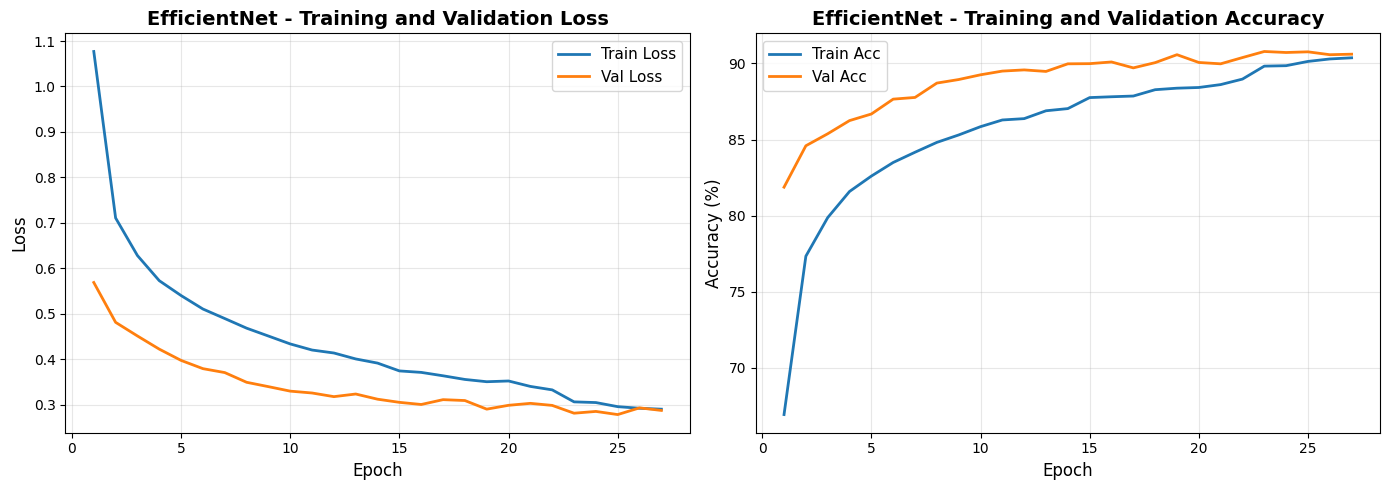

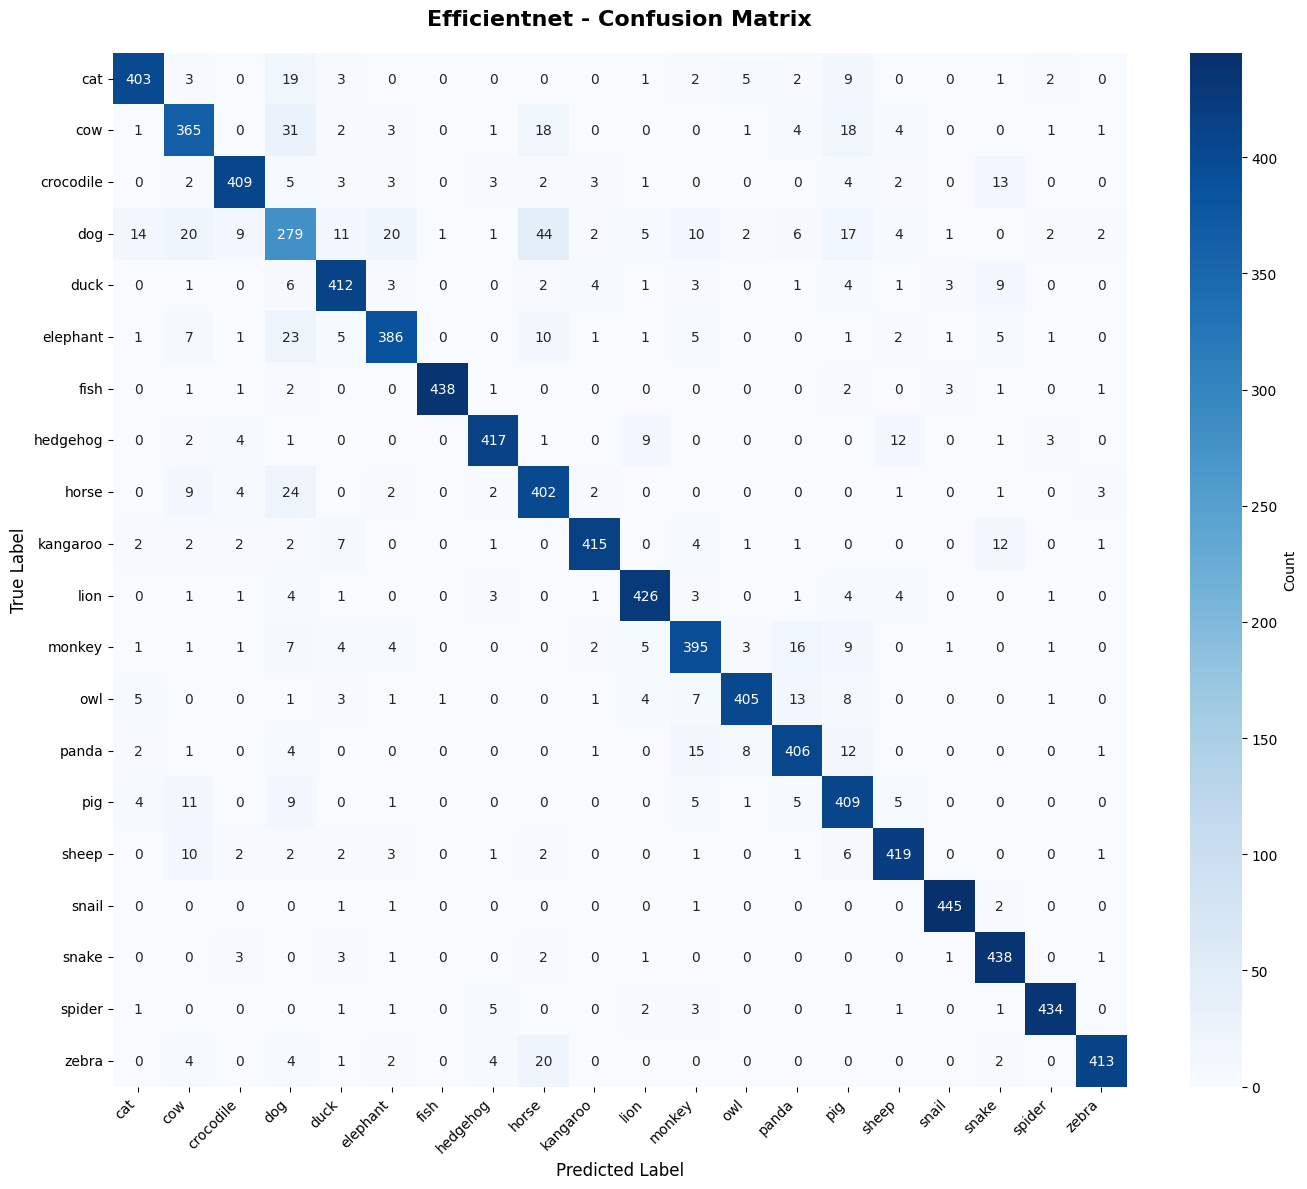

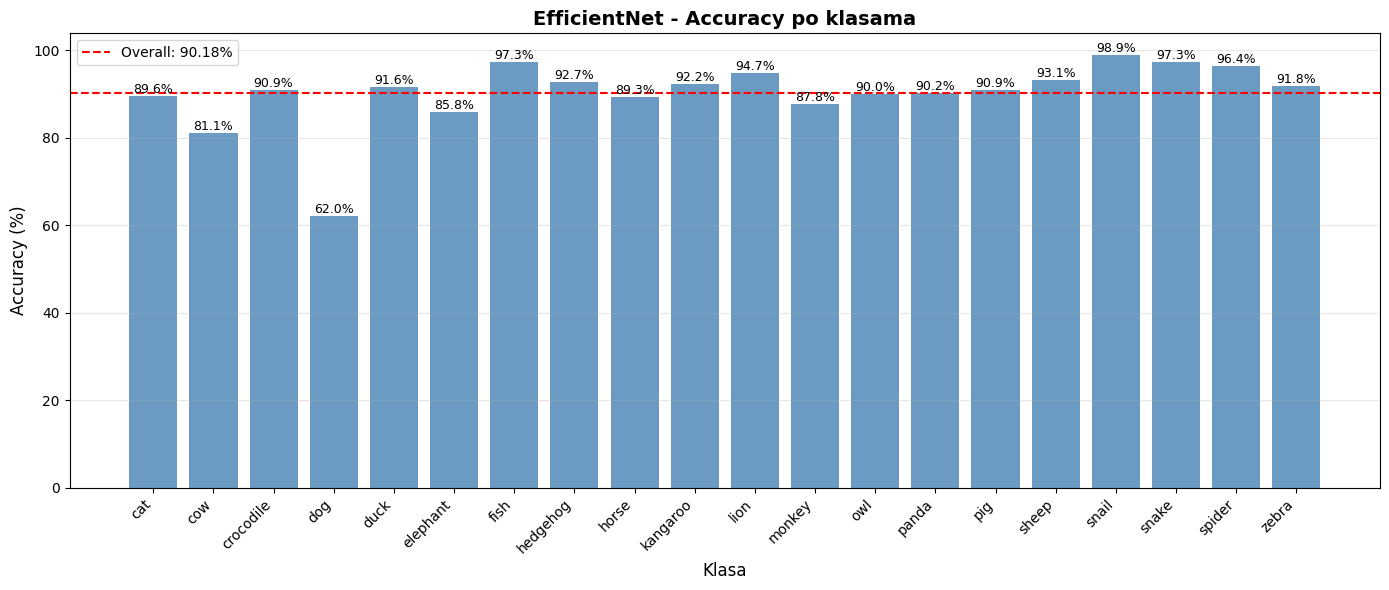

In [16]:
# Evaluacione metrike i vizualizacija
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(config.DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print('TEST SET REZULTATI')
print(f'Accuracy:  {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall:    {recall*100:.2f}%')
print(f'F1 Score:  {f1*100:.2f}%')

print('\nPo klasama:')
print(classification_report(all_labels, all_preds, target_names=config.CLASSES))

cm = confusion_matrix(all_labels, all_preds)

# Accuracy po klasama
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print('\nAccuracy po klasama:')
for i, class_name in enumerate(config.CLASSES):
    print(f'{class_name:12s}: {per_class_acc[i]*100:5.2f}%')


# Train i val loss i accuracy kroz epohe prikaz
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Ogranicavamo podatke za plotovanje na stvaran broj epoha (u slucaju ranog zaustavljanja)
epochs_ran = len(train_losses)
epochs_range = range(1, epochs_ran + 1)

ax1.plot(epochs_range, train_losses, label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('EfficientNet - Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, train_accs, label='Train Acc', linewidth=2)
ax2.plot(epochs_range, val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('EfficientNet - Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnet_trainig_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=config.CLASSES, yticklabels=config.CLASSES,
            cbar_kws={'label': 'Count'})
plt.title('Efficientnet - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('efficientnet_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Accuracy po klasama bar chart
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(range(len(config.CLASSES)), per_class_acc * 100, color='steelblue', alpha=0.8)
ax.set_xlabel('Klasa', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('EfficientNet - Accuracy po klasama', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(config.CLASSES)))
ax.set_xticklabels(config.CLASSES, rotation=45, ha='right')
ax.axhline(y=accuracy*100, color='r', linestyle='--', label=f'Overall: {accuracy*100:.2f}%')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('efficientnet_perclass_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()